In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.callbacks import EarlyStopping

In [3]:
from google.colab import files

files.upload()

Saving heat_data.csv to heat_data.csv


{'heat_data.csv': b'\xef\xbb\xbf6046.395\r\n6014.94\r\n6013.05\r\n5978.22\r\n6165.06\r\n7182.15\r\n8065.185\r\n10089.78\r\n11262.66\r\n11447.34\r\n11473.935\r\n10850.37\r\n10572.405\r\n11328\r\n11038.56\r\n10857.93\r\n10780.44\r\n10344.93\r\n8965.77\r\n8387.43\r\n7887.525\r\n7360.08\r\n6793.08\r\n6473.265\r\n6161.55\r\n6057.87\r\n6087.165\r\n6116.19\r\n6566.01\r\n7175.265\r\n8169\r\n10230.99\r\n11284.26\r\n11480.685\r\n11466.105\r\n10668.795\r\n10244.895\r\n10910.58\r\n10830.255\r\n10700.79\r\n10474.125\r\n10102.335\r\n8957.535\r\n8284.425\r\n7903.32\r\n7363.05\r\n6821.835\r\n6493.515\r\n6109.035\r\n6072.72\r\n6059.49\r\n6097.56\r\n6319.77\r\n7129.5\r\n8133.765\r\n9753.765\r\n11307.345\r\n11422.365\r\n11572.89\r\n10752.9\r\n10233.555\r\n10873.455\r\n10855.77\r\n10759.38\r\n10760.055\r\n10189.005\r\n8991.285\r\n8470.86\r\n8124.72\r\n7511.82\r\n6946.17\r\n6685.62\r\n6540.36\r\n6423.72\r\n6733.95\r\n6798.48\r\n6806.58\r\n8274.57\r\n9784.95\r\n10685.805\r\n11893.65\r\n12275.97\r\n12248.295

In [4]:
!ls

heat_data.csv  sample_data


In [5]:
#1시간단위 데이터 컬럼
heat_data = pd.read_csv("heat_data.csv", header=None)
heat_data.head()

,0
0,6046.395
1,6014.940
2,6013.050
3,5978.220
4,6165.060


In [6]:
heat_data.shape

(1200, 1)

In [7]:
heat_data = np.array(heat_data) 

#전체 날짜 수(1시간단위=>하루는 24시간)
number_of_whole_day = int(heat_data.shape[0]/24)
print(f"Number of Whole day: {number_of_whole_day}")

#하루를 예측하는 것이므로 하루를 제외한 나머지는 train+vald으로 지정
number_of_trainval_day=number_of_whole_day-1
print(f"Number of train and validation day: {number_of_trainval_day}")

#train+val에서 80%를 훈련셋으로 지정  
number_of_train_day = int(number_of_trainval_day * 0.8) 
print(f"Number of train day: {number_of_train_day}")

Number of Whole day: 50
Number of train and validation day: 49
Number of train day: 39


In [8]:
#train_data중에서 
train_data=heat_data[:number_of_train_day*24]
print(f"Number of train data: {train_data.shape}")

valid_data=heat_data[number_of_train_day*24:-24]
print(f"Number of validation data: {valid_data.shape}")

test_data = heat_data[-24:]
print(f"Number of test data: {test_data.shape}")

Number of train data: (936, 1)
Number of validation data: (240, 1)
Number of test data: (24, 1)


In [9]:
#데이터 전처리 
#이유1.LSTM내부적으로 선형 결합의 결과값을 활성화 함수를 거치는데, 
#이때 입력값을 0과 1사이로 만든다. 입력값을 0과 1사이로 만들지 않는다면 
#그레디언트 소실이 발생할 가능성이 커짐.

#이유2.입력 특성이 두가지 이상인 경우, 두 특성의 범위가 많이 다르면 모델성능 떨어짐.

minmax_scaler = MinMaxScaler(feature_range=(0, 1))

In [17]:
#데이터 스케일링(0,1 사이값으로 변환)
min_max_normalized_train_data=minmax_scaler.fit_transform(train_data)

#fit은 사용하면 안됨.train data에서 fit했던 기준들을 이용해야하기 때문
min_max_normalized_valid_data = minmax_scaler.transform(valid_data)
min_max_normalized_test_data = minmax_scaler.transform(test_data)

#스케일링된 결과
print(min(train_data), max(train_data))
print(min(min_max_normalized_train_data), max(min_max_normalized_train_data))

[5756.55] [14598.105]
[0.] [1.]


In [18]:
#numpy를 pandas로 변환
min_max_normalized_train_data = pd.DataFrame(min_max_normalized_train_data)[0]
min_max_normalized_valid_data = pd.DataFrame(min_max_normalized_valid_data)[0]
min_max_normalized_test_data = pd.DataFrame(min_max_normalized_test_data)[0]

In [21]:
#학습데이터, 결과데이터 배열로 return  
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    start = sequence.index.start
    for i in range(start, len(sequence)+start):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > start + len(sequence)-1:
            break
        # gather input and output parts of the pattern
        if start > 90:
            a = i - start
            b = end_ix - start
        else:
            a = i
            b = end_ix
        # seq_x, seq_y = sequence[a:b], sequence[end_ix]
        seq_x, seq_y = sequence[a:b], sequence[b]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
#데이터 split을 위한 값. 2개의 input, 1개의 result   
## Ex) [1, 2, 3, 4, 5], n_steps = 2 -> [[1, 2, [3]], [2, 3, [4]], [3, 4, [5]]]

n_step = 2

x_train, y_train = split_sequence(min_max_normalized_train_data, n_step)
x_valid, y_valid = split_sequence(min_max_normalized_valid_data, n_step)
x_test, y_test = split_sequence(min_max_normalized_test_data, n_step)

print(x_train.shape)
print(y_train.shape)

(934, 2)
(934,)


In [23]:
#RNN- 데이터 형변환 [samples, timesteps, features]
n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

print(x_train.shape)  #shape=(2,1) 934개 
print(y_train.shape)  #정답

(934, 2, 1)
(934,)


In [25]:
#모델 정의
#모델 성능(오류율이 5%미만이면 break, 아니면 10번 시도 후에 break)
i = 0
while True and i < 10:
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_step, n_features)))  #input_shape=(2,1)
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    #model training start
    #train data로 학습후, val data로 성능평가 
    model.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_valid, y_valid), callbacks=[early_stop])

    #학습모델로 test data 예측  
    yhat = model.predict(x_test, verbose=0)
    yhat = minmax_scaler.inverse_transform(yhat)  #원래값으로 변경

    #Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:])  #test_data[n_step:]=test데이터[0],[1]의 y_train값
    if result*100 < 5:
        break
    else:
        del model
        i+=1

Epoch 1/100
30/30 [==============================] - 1s 27ms/step - loss: 0.1468 - val_loss: 0.0508
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0426 - val_loss: 0.0310
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0213 - val_loss: 0.0167
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0122 - val_loss: 0.0126
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 9/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 10/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0112

In [26]:
#모델 저장
#-나중에 모델을 재구성하기 위한 모델의 구성 정보
#-모델를 구성하는 각 뉴런들의 가중치
#-손실함수, 최적하기 등의 학습 설정
#-재학습을 할 수 있도록 마지막 학습 상태
model.save("prediction_model.h5")

#* 참고 이후 사용법
# # 2. 모델 불러오기
# from keras.models import load_model
# model = load_model('prediction_model.h5')

# # 3. 모델 사용하기
# yhat = model.predict_classes(xhat) #predict_classes=가장 확률이 높은 클래스 인덱스를 알려줌

In [31]:
# 24로 맞추고 싶다면 테스트 데이터를 24가 아니라 전날 23시 24시 데이터를 추가해서 26으로 맞추면 됨.
print(test_data[n_step:].shape)
print(yhat.shape)

(22, 1)
(22, 1)


In [29]:
#Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:])*100
print(result)

4.251880779520302


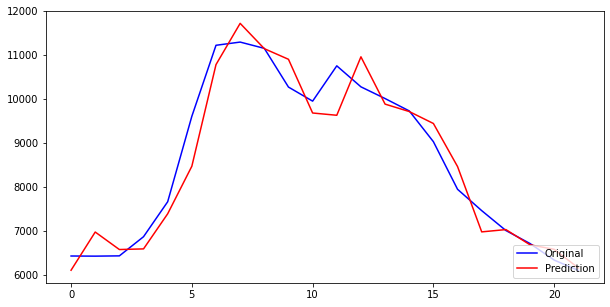

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(test_data[n_step:], 'b', label='Original')
ax1.plot(yhat, 'r', label='Prediction')
ax1.legend(loc="lower right")

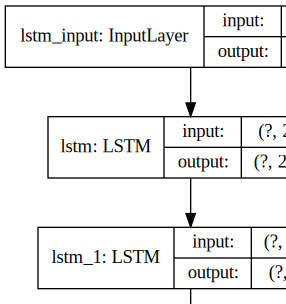

In [32]:
#모델 아키텍쳐 보기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))